In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import necessary libraries
import pandas as pd

# Read CSV file from Google Drive
file_path = "/content/drive/My Drive/SWPPX.csv"
#Only attempting to analyze the Close value
df = pd.read_csv(file_path, parse_dates=True, index_col='Date', usecols=['Date', 'Close'])

In [3]:
# Display the first few rows of the DataFrame
print(df.head())

            Close
Date             
1997-06-01  13.67
1997-07-01  14.75
1997-08-01  13.92
1997-09-01  14.68
1997-10-01  14.19


In [4]:
# Display the last few rows of the DataFrame
print(df.tail())

                Close
Date                 
2024-01-01  74.320000
2024-02-01  78.290001
2024-03-01  80.809998
2024-04-01  77.500000
2024-05-01  82.000000


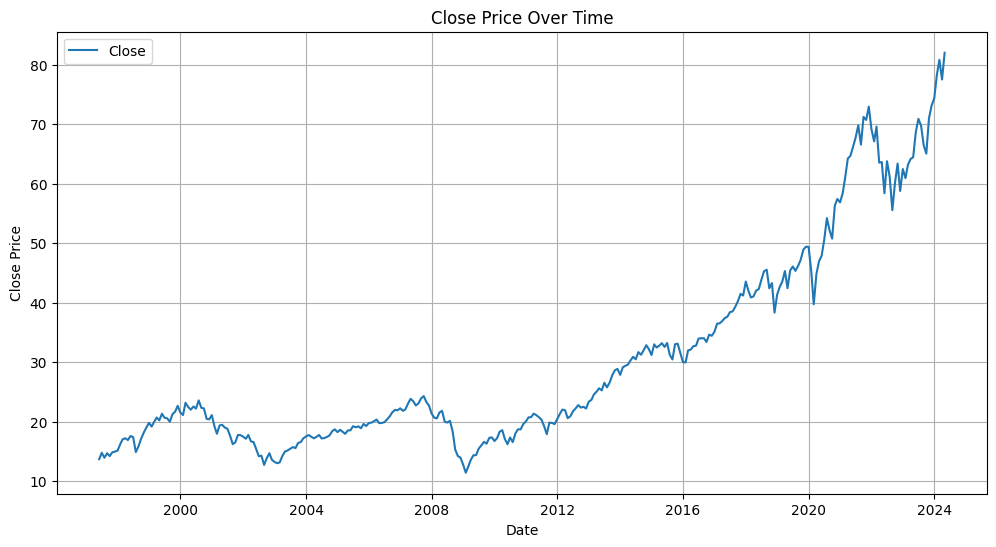

In [5]:
import matplotlib.pyplot as plt

# Plot the 'Close' values
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Close')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price Over Time')
plt.grid(True)
plt.legend()
plt.show()

In [6]:
from sklearn.linear_model import LinearRegression

# Create a linear regression model
model = LinearRegression()

# Prepare the data for linear regression
X = df.index.to_julian_date().values.reshape(-1, 1)  # Convert date index to Julian date for linear regression
y = df['Close'].values.reshape(-1, 1)

# Fit the model
model.fit(X, y)

# Predict the 'Close' values using the linear regression model
predicted_close = model.predict(X)

# Add the predicted 'Close' values as a new column in the DataFrame
df['Line_of_Best_Fit'] = predicted_close

# Print the updated DataFrame to verify the new column
print(df.head())

            Close  Line_of_Best_Fit
Date                               
1997-06-01  13.67          5.257907
1997-07-01  14.75          5.410130
1997-08-01  13.92          5.567427
1997-09-01  14.68          5.724724
1997-10-01  14.19          5.876948


In [7]:
from sklearn.metrics import mean_absolute_error

# Extract the last 12 months for 'Close' and 'Line_of_Best_Fit'
last_12_close = df['Close'].iloc[-12:].values
last_12_line_of_best_fit = df['Line_of_Best_Fit'].iloc[-12:].values

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(last_12_close, last_12_line_of_best_fit)

print("Mean Absolute Error (MAE) for the last 12 months:")
print(mae)

Mean Absolute Error (MAE) for the last 12 months:
18.85094963632059


In [8]:
import numpy as np

# Calculate the mean of 'Close' values for the last 12 points
mean_close = np.mean(last_12_close)

# Calculate the relative MAE
relative_mae = mae / mean_close

print("Relative Mean Absolute Error (MAE) for the last 12 points:")
print(relative_mae)

Relative Mean Absolute Error (MAE) for the last 12 points:
0.2577232163974407


In [9]:
# Remove the 'Line_of_Best_Fit' column from the DataFrame
df.drop(columns=['Line_of_Best_Fit'], inplace=True)

# Print the DataFrame to verify the removal of the column
print(df.head())

            Close
Date             
1997-06-01  13.67
1997-07-01  14.75
1997-08-01  13.92
1997-09-01  14.68
1997-10-01  14.19


In [10]:
len(df)

324

In [11]:
#Try to predict the last year of the dataset, split test/train split
len(df)-12

312

In [12]:
test_size=12
test_ind=len(df)-test_size

In [13]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [14]:
test

,Close
Date,
2023-06-01,68.669998
2023-07-01,70.879997
2023-08-01,69.750000
2023-09-01,66.419998
2023-10-01,65.029999
2023-11-01,70.959999
2023-12-01,73.099998
2024-01-01,74.320000
2024-02-01,78.290001


In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [16]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [17]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [18]:
# Use 6 months of historical data at a time to predict the next month
length = 6

In [19]:
generator = TimeseriesGenerator(scaled_train,scaled_train, length=length, batch_size=1)

In [20]:
X,y = generator[0]

In [21]:
X

array([[[0.03688658],
        [0.05443614],
        [0.04094897],
        [0.05329867],
        [0.04533637],
        [0.0558986 ]]])

In [22]:
y

array([[0.05768606]])

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [24]:
#Specify one feature
n_features = 1

In [25]:
#Create the model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(length, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 100)            40800     
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 71051 (277.54 KB)
Trainable params: 71051 (277.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5)
validation_generator = TimeseriesGenerator(scaled_test,scaled_test,length=length,batch_size=1)
model.fit_generator(generator,epochs=20, validation_data=validation_generator, callbacks = [early_stop])

<ipython-input-26-fa387a75b652>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=20, validation_data=validation_generator, callbacks = [early_stop])


Epoch 1/20
306/306 [==============================] - 16s 25ms/step - loss: 0.0570 - val_loss: 0.0319
Epoch 2/20
306/306 [==============================] - 5s 17ms/step - loss: 0.0405 - val_loss: 0.1089
Epoch 3/20
306/306 [==============================] - 3s 9ms/step - loss: 0.0339 - val_loss: 0.1885
Epoch 4/20
306/306 [==============================] - 4s 12ms/step - loss: 0.0301 - val_loss: 0.1756
Epoch 5/20
306/306 [==============================] - 3s 9ms/step - loss: 0.0321 - val_loss: 0.0733
Epoch 6/20
306/306 [==============================] - 3s 9ms/step - loss: 0.0293 - val_loss: 0.0598


In [27]:
losses = pd.DataFrame(model.history.history)

<Axes: >

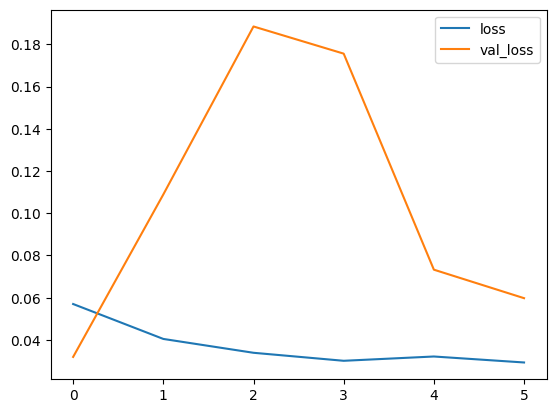

In [28]:
losses.plot()

In [58]:
#Create a prediction on the last 12 months that we already know the results of
test_preds = []
first_eval_batch = scaled_train[-length:]
curr_batch = first_eval_batch.reshape((1,length,n_features))
for i in range(len(test)):
  curr_pred = model.predict(curr_batch)[0]
  test_preds.append(curr_pred)
  curr_batch = np.append(curr_batch[:,1:,:],[[curr_pred]],axis=1)

1/1 [==============================] - 0s 23ms/step


In [59]:
true_preds = scaler.inverse_transform(test_preds)

In [60]:
test['Predictions']=true_preds

<ipython-input-60-7bbea6245e38>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions']=true_preds


In [61]:
test

,Close,Predictions
Date,,
2023-06-01,68.669998,65.368819
2023-07-01,70.879997,66.336097
2023-08-01,69.750000,67.061817
2023-09-01,66.419998,68.018200
2023-10-01,65.029999,68.817018
2023-11-01,70.959999,69.606636
2023-12-01,73.099998,70.430132
2024-01-01,74.320000,71.239331
2024-02-01,78.290001,72.027936


In [62]:
# Calculate MAE
mae = (test['Close'] - test['Predictions']).abs().mean()
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 4.0721690342506305


In [63]:
test_mean = test['Close'].mean()
mae_to_avg_price = mae/test_mean
mae_to_avg_price #Determine the relative error of the predictions (About 5.6%), much better than the relative error of the line of best fit (25%)

0.05567319002322565

<Axes: xlabel='Date'>

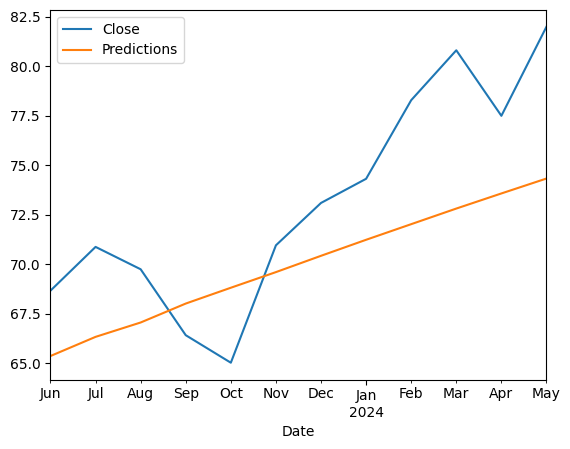

In [65]:
test.plot() #Plot the predictions compared to the actual close values

In [143]:
#Now we will try to predict the next year of data by processing the entire dataset as training data, and not having a test set
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [144]:
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(length, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 12, 100)           40800     
                                                                 
 lstm_9 (LSTM)               (None, 50)                30200     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 71051 (277.54 KB)
Trainable params: 71051 (277.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [155]:
#Using a large enough amount of epochs, but not too large based on previous training
model.fit_generator(generator,epochs=6)

Epoch 1/6
  3/312 [..............................] - ETA: 8s - loss: 0.0112 

<ipython-input-155-278e93a89c96>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=6)


312/312 [==============================] - 7s 21ms/step - loss: 0.0253
Epoch 2/6
312/312 [==============================] - 4s 13ms/step - loss: 0.0268
Epoch 3/6
312/312 [==============================] - 4s 14ms/step - loss: 0.0257
Epoch 4/6
312/312 [==============================] - 5s 17ms/step - loss: 0.0271
Epoch 5/6
312/312 [==============================] - 5s 16ms/step - loss: 0.0249
Epoch 6/6
312/312 [==============================] - 8s 24ms/step - loss: 0.0238


In [156]:
#Determine the forecast
forecast = []
periods = 12
first_eval_batch = scaled_train[-length:]
curr_batch = first_eval_batch.reshape((1,length,n_features))
for i in range(periods):
  curr_pred = model.predict(curr_batch)[0]
  forecast.append(curr_pred)
  curr_batch = np.append(curr_batch[:,1:,:],[[curr_pred]],axis=1)

1/1 [==============================] - 0s 25ms/step


In [157]:
forecast = scaler.inverse_transform(forecast)

In [158]:
df

,Close
Date,
1997-06-01,13.670000
1997-07-01,14.750000
1997-08-01,13.920000
1997-09-01,14.680000
1997-10-01,14.190000
...,...
2024-01-01,74.320000
2024-02-01,78.290001
2024-03-01,80.809998


In [159]:
forecast

array([[66.37004854],
       [67.65737603],
       [69.07842301],
       [70.59989441],
       [72.17468855],
       [73.84229586],
       [75.57050702],
       [77.36209509],
       [79.22551865],
       [81.14412465],
       [83.12612957],
       [85.16442469]])

In [160]:
#Creating a forecast index for every month we made a prediction for
forecast_index = pd.date_range(start = '2024-06-01', periods = periods, freq = "MS")

In [161]:
forecast_index

DatetimeIndex(['2024-06-01', '2024-07-01', '2024-08-01', '2024-09-01',
               '2024-10-01', '2024-11-01', '2024-12-01', '2025-01-01',
               '2025-02-01', '2025-03-01', '2025-04-01', '2025-05-01'],
              dtype='datetime64[ns]', freq='MS')

In [162]:
#Create a forecast dataframe using the forecasts and the created forecast index
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])

In [163]:
forecast_df

,Forecast
2024-06-01,66.370049
2024-07-01,67.657376
2024-08-01,69.078423
2024-09-01,70.599894
2024-10-01,72.174689
2024-11-01,73.842296
2024-12-01,75.570507
2025-01-01,77.362095
2025-02-01,79.225519
2025-03-01,81.144125


(544.0, 664.0)

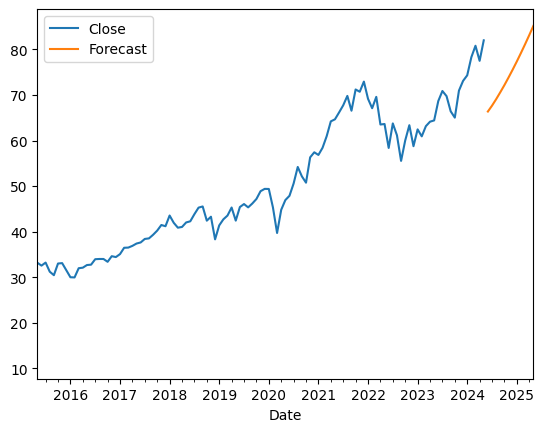

In [164]:
#Plot the original graph, and the forecast
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2015-05-01','2025-05-01')